In [39]:
import time
import os
import subprocess
import cv2
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recording Video with a webcam

In [40]:
def capture_video(folder_name, delay_s=3, video_duration_s = 5):
    folder_path = f"../data/videos/{folder_name}"
    os.makedirs(folder_path, exist_ok=True)

    print("\nTaking video in...")
    while delay_s > 0:
        print(f"{delay_s}...")
        time.sleep(1)
        delay_s -= 1

    raw_video_path = f"{folder_path}/i420.avi"
    command = f"ffmpeg -y -f v4l2 -framerate 30 -i /dev/video0 -t {video_duration_s} {raw_video_path}"
    subprocess.run(command, shell=True)

    formats = {
        "mp4.mp4": "libx264",   # MP4 format
        "divx.avi": "mpeg4",    # DivX format
        "flv.flv": "flv",       # FLV format
        "xvid.avi": "libxvid"   # Xvid format
    }

    for filename, codec in formats.items():
        output_path = f"{folder_path}/{filename}"
        command = f"ffmpeg -i {raw_video_path} -c:v {codec} {output_path}"
        subprocess.run(command, shell=True)

capture_video("test_1")
capture_video("test_2")



Taking video in...
3...
2...
1...


ffmpeg version n7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.1 (GCC) 20240910
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable

KeyboardInterrupt: 

# Pricessing videos into DF

In [41]:
def get_df_video_info(duration = 5, fps=30):
    base_path = "../data/videos/"
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            if file_path[-4:] == ".jpg" or file_path[-4:] == ".ppm":
                continue

            cap = cv2.VideoCapture(file_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, 1)
            _, frame= cap.read()
            cv2.imwrite(f"{folder_path}/reference.ppm", frame)
            ref_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            cap = cv2.VideoCapture(file_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(duration*fps/3))
            _, frame= cap.read()
            cv2.imwrite(f"{folder_path}/{file}.jpg", frame)
            compare_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))
                
                try:
                    # Compute SSIM
                    ssim_score = ssim(ref_img, compare_img)
                except:
                    ssim_score = -1
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024
                if ref_img is not None:
                    height, width = ref_img.shape[:2]
                image_size = f"{width}x{height}" 
                data.append([folder_name, file, duration, fps, image_size, file_size, ssim_score, mse_score])

    df = pd.DataFrame(data, columns=["test no.", "video format", "duration", "fps", "image size", "file size", "SSIM", "MSE"])
    return df

df = get_df_video_info()
df.head(10)

,test no.,video format,duration,fps,image size,file size,SSIM,MSE
0,test_2,i420.avi,5,30,640x360,228.121094,-1,1172.298491
1,test_2,mp4.mp4,5,30,640x360,241.905273,-1,1163.752935
2,test_2,flv.flv,5,30,640x360,265.048828,-1,1226.191628
3,test_2,xvid.avi,5,30,640x360,181.621094,-1,1840.005887
4,test_2,divx.avi,5,30,640x360,234.417969,-1,1189.728520
5,test_1,i420.avi,5,30,640x360,208.367188,-1,5636.228446
6,test_1,mp4.mp4,5,30,640x360,237.468750,-1,1014.240305
7,test_1,flv.flv,5,30,640x360,252.632812,-1,1058.254031
8,test_1,xvid.avi,5,30,640x360,177.925781,-1,1675.584502
9,test_1,divx.avi,5,30,640x360,224.021484,-1,1000.033597


In [24]:
df.drop("SSIM", axis=1).head(10)

,test no.,video format,duration,fps,image size,file size,MSE
0,test_2,i420.avi,5,30,640x360,228.121094,1172.298491
1,test_2,mp4.mp4,5,30,640x360,241.905273,1163.752935
2,test_2,flv.flv,5,30,640x360,265.048828,1226.191628
3,test_2,xvid.avi,5,30,640x360,181.621094,1840.005887
4,test_2,divx.avi,5,30,640x360,234.417969,1189.728520
5,test_1,i420.avi,5,30,640x360,219.179688,1029.909482
6,test_1,mp4.mp4,5,30,640x360,237.468750,1014.240305
7,test_1,flv.flv,5,30,640x360,252.632812,1058.254031
8,test_1,xvid.avi,5,30,640x360,177.925781,1675.584502
9,test_1,divx.avi,5,30,640x360,224.021484,1000.033597


In [35]:
def get_df_image_info():
    base_path = "../data/videos/"
    image_format = "jpg"
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)

        ref_img_path = os.path.join(folder_path, "reference.ppm")
        ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
        
        for file in os.listdir(folder_path):
            if not file.endswith(f".{image_format}"):
                continue

            file_path = os.path.join(folder_path, file)
            compare_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert to KB
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                image_size = f"{width}x{height}" 
                data.append([folder_name, file, image_size, f"{file_size:.2f} KB", round(ssim_score, 4), round(mse_score, 4)])

    df = pd.DataFrame(data, columns=["Test Folder", "Format", "Resolution", "File Size", "SSIM", "MSE"])
    return df

df_images = get_df_image_info()
df_images.head(10)

,Test Folder,Format,Resolution,File Size,SSIM,MSE
0,test_2,flv.flv.jpg,640x360,23.25 KB,0.7477,1455.0272
1,test_2,divx.avi.jpg,640x360,23.54 KB,0.7472,1457.5834
2,test_2,i420.avi.jpg,640x360,24.07 KB,0.7463,1459.5864
3,test_2,mp4.mp4.jpg,640x360,28.38 KB,0.7476,1437.3036
4,test_2,xvid.avi.jpg,640x360,28.13 KB,0.7441,1473.2580
5,test_1,flv.flv.jpg,640x360,24.32 KB,0.7820,965.9883
6,test_1,divx.avi.jpg,640x360,24.16 KB,0.7820,968.2753
7,test_1,i420.avi.jpg,640x360,24.48 KB,0.7816,967.3087
8,test_1,mp4.mp4.jpg,640x360,29.02 KB,0.7882,919.5356
9,test_1,xvid.avi.jpg,640x360,27.40 KB,0.7790,965.5221


# Visualisation

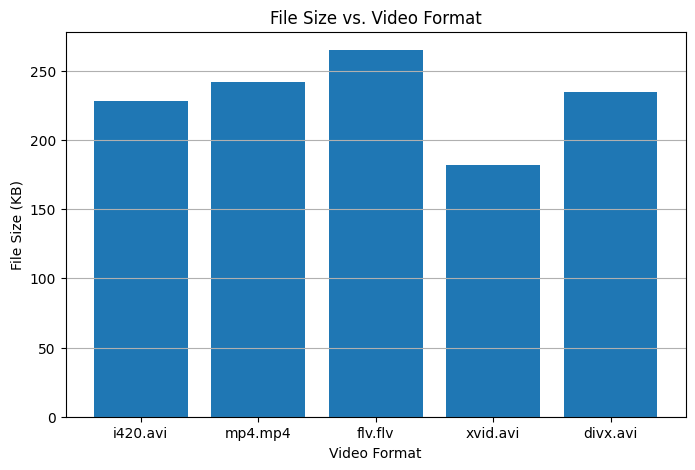

In [36]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["file size"])
plt.xlabel("Video Format")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Video Format")
plt.grid(axis="y")
plt.show()

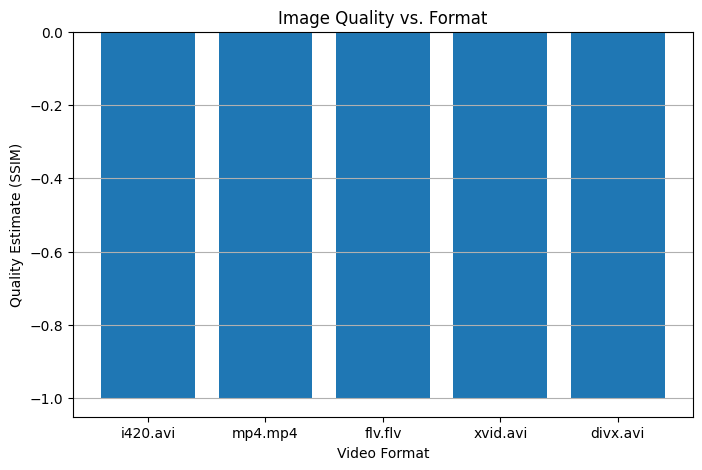

In [37]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["SSIM"])
plt.xlabel("Video Format")
plt.ylabel("Quality Estimate (SSIM)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()

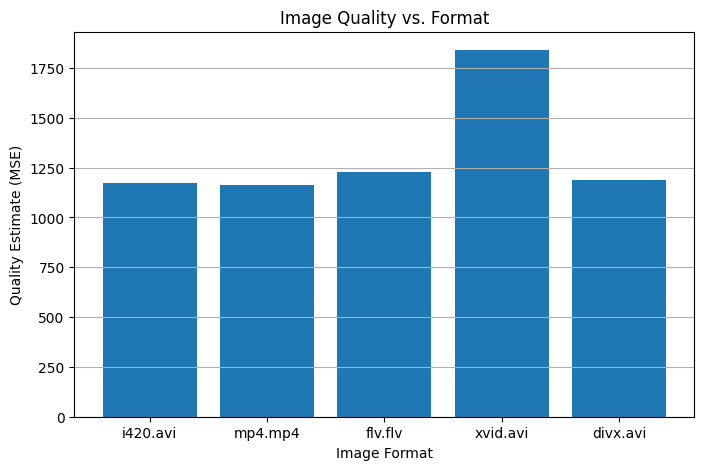

In [38]:
plt.figure(figsize=(8, 5))
plt.bar(df["video format"], df["MSE"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (MSE)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()